<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S12/EVA4_Session_12_YOLO_Anchor_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA4 Session-12
## Assignment-B

Explanation of the file Attributes:
- **info:** Project Version and Creation Details
- **images:** Details of image being annotated
  - *id:* index of image starting from '0'
  - *width:* width of the image being annotated
  - *height:* height of the image being annotated
  - *file_name:* original name of the image file
  - *license:* License ID for the image
  - *date_captured:* Date of Image Capture
- **annotations:** Details of the Annotation for each object
  - *id:* annotated object id. Starts from '0', increases for every object annotated.
  - *image_id:* Corresponds to the image to which the object belongs
  - *segmentation:* Bounding box coordinates for all the points in the format (x,y)
  - *area:* Area of the bounding box, calculated from segmentations
  - *bbox:* Coordinate of the top-left point(when drawn from top-left). And width, height factor for the BB
  - *iscrowd:* iscrowd=0, if the BB is for single object, iscrowd=1, if collection of objects.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [0]:
def load_json(path):
    with open(path) as f:
        img_annotations = eval(f.read())
    return img_annotations

In [0]:
def fetch_data_points(img_annotations):
    data_points = []
    for annotation in img_annotations['annotations']:
        bbox = annotation['bbox']
        img = img_annotations['images'][int(annotation['image_id'])]

        # Normalize the height and width of the bounding box
        data_points.append((
            bbox[2] / img['width'],
            bbox[3] / img['height']
        ))
    return np.array(data_points)

In [0]:
img_annotations = load_json('drive/My Drive/EVA4/Session-12/Assignment-B/dogs_annotation.json')
data_points = fetch_data_points(img_annotations)

Text(0, 0.5, 'height')

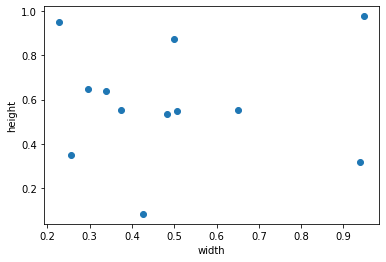

In [7]:
plt.scatter(data_points[:, 0], data_points[:, 1])
plt.xlabel('width')
plt.ylabel('height')

Text(0, 0.5, 'log(height)')

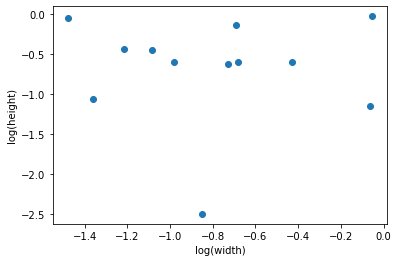

In [8]:
plt.scatter(np.log(data_points[:, 0]), np.log(data_points[:, 1]))
plt.xlabel('log(width)')
plt.ylabel('log(height)')

In [0]:
class KMeans:
    def __init__(self, num_clusters, points, iterations):
        self.num_clusters = num_clusters
        self.points = points
        self.iterations = iterations

        self.centroids = self.initialize_centroids()
        self.closest = None
        self.mean_iou = None

        self.find_clusters()
        self.iou()

    def initialize_centroids(self):
        centroids = self.points.copy()
        np.random.shuffle(centroids)
        return centroids[:self.num_clusters]

    def closest_centroid(self):
        distances = np.sqrt(
            ((self.points - self.centroids[:, np.newaxis]) ** 2).sum(axis=2)
        )
        self.closest = np.argmin(distances, axis=0)

    def move_centroids(self):
        self.centroids =  np.array([
            self.points[self.closest == k].mean(axis=0)
            for k in range(self.centroids.shape[0])
        ])
    
    def find_clusters(self):
        for _ in range(self.iterations):
            self.closest_centroid()
            self.move_centroids()
    
    def iou(self):
        closest_centroids = self.centroids[self.closest]
        width = np.minimum(
            closest_centroids[:, 0], self.points[:, 0]
        )
        height = np.minimum(
            closest_centroids[:, 1], self.points[:, 1]
        )

        intersection = width * height
        points_area = self.points[:, 0] * self.points[:, 1]
        cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

        self.mean_iou = np.mean(
            intersection / (points_area + cluster_area - intersection)
        )

In [0]:
iou_list = []
kmeans_model = {}

# Cluster Trial Range
num_clusters_start = 1
num_clusters_end = 16

# Count of iterations
iterations = 300

# Run K-Means for each 'n' number of clusters
for k in range(num_clusters_start, num_clusters_end + 1):
    kmeans_model[k + 1] = KMeans(k + 1, data_points, iterations)
    iou_list.append(kmeans_model[k + 1].mean_iou)

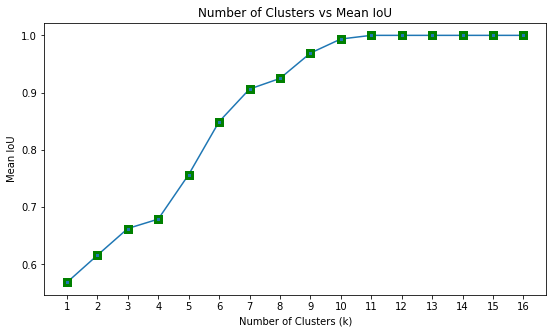

In [11]:
fig = plt.figure(figsize=(9, 5))

_ = plt.plot(iou_list, '-s', markeredgecolor='green', markeredgewidth=3)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean IoU')

plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
plt.title('Number of Clusters vs Mean IoU')

fig.savefig('cluster_vs_mean_iou_graph.png')

In [0]:
def display_clusters(kmeans):
    num_clusters = kmeans.num_clusters

    # Plot points for each cluster
    for cluster_id in range(num_clusters):
        points = kmeans.points[kmeans.closest == cluster_id]
        plt.scatter(points[:, 0], points[:, 1])
    
    # Plot centroids
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='black', s=90, marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k = {num_clusters}')

    # Save figure
    plt.savefig(f'cluster_plot_k{num_clusters}.png')

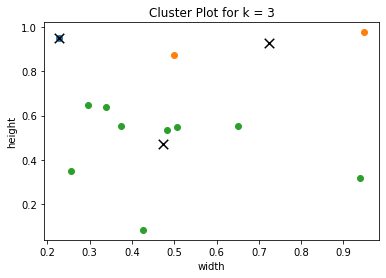

In [13]:
# Plot for k = 3
display_clusters(kmeans_model[3])

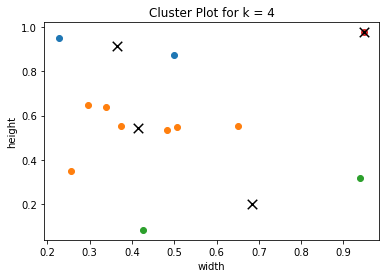

In [14]:
# Plot for k = 4
display_clusters(kmeans_model[4])

In [0]:
def make_anchor_boxes(ax, clusters, edgecolor='b', alpha=1):
    """Make anchor boxes given cluster centroids."""

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(
        errorboxes, facecolor='None', alpha=alpha, edgecolor=edgecolor
    )

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(
        xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None'
    )

    return artists

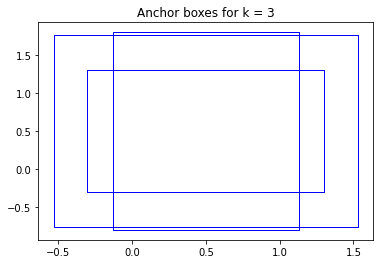

In [16]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
_ = make_anchor_boxes(ax, kmeans_model[3].centroids)

# Show plot
plt.title('Anchor boxes for k = 3')
plt.show()
fig.savefig('anchor_bbox_k3.png')

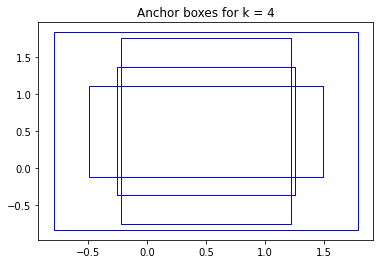

In [17]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
_ = make_anchor_boxes(ax, kmeans_model[4].centroids)

# Show plot
plt.title('Anchor boxes for k = 4')
plt.show()
fig.savefig('anchor_bbox_k4.png')
